## t-distributed Stochastic Neighbor Embedding(t-SNE)

t-SNE는 SNE 기법에서 발전된 방법론으로 실제 데이터 분석에서 상당히 많이 사용되는 기법이다. (시각화에 용이)

고차원 D에서 데이터 j를 이웃으로 뽑을 확률과, (축소된) 저차원 d에서 데이터 j를 이웃으로 뽑을 확률을 최대한 유사하게 만드는 것이 주 목표이다.

이런 관점에서는 LLE와 매우 유사한 모습을 가지고 있다.

따라서 t-SNE는 두 확률 분포 (고차원, 저차원)의 다름의 정도를 판단할 수 있는 Kullback-Leiber Divergence (KL-Divergence)를 cost function으로 사용한다.

본 튜토리얼에서는 resnet18 모델의 마지막 fully connected layer의 feature 수인 512를 시각화하기 위해 2차원으로 축소한다


### 1. Import Packages and Modules

In [30]:
from sklearn.manifold import TSNE # 
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")

### 2. Check Device

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 3. Data Load (CIFAR 10)

In [32]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16)

Files already downloaded and verified


### 4. Identitiy Class for Visualization

In [64]:
# 입력된 값을 그대로 뱉는 (x -> x) layer 생성

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

### 5. Use Resnet18

In [62]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features # Resnet18 모델의 FC의 node 수 확인
model.fc = nn.Linear(num_ftrs, 10) # Resnet18 모델의 FC output size를 10으로 수정 (CIFAR-10) 데이터 사용하기 때문, 10 class classification
model = model.to(device)

In [63]:
# t-SNE를 사용해서 시각화하기 위해 classifier 들어가기 직전에 값을 뽑아낼 것 (512 features)
# (avgpool): AdaptiveAvgPool2d(output_size=(1, 1)) 이 부분 이후
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
# CIFAR 10으로 pretrained 된 Resnet 18 모델의 가중치 불러오기
model.load_state_dict(torch.load('./models/cifar10_resnet18.pth'))
model.fc = Identity() # 모델 출력 부분을 위에서 만든 Identity Class로 변경! (512개 feature 그대로 나오게)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 6. Check Distribution of CIFAR 10 data

In [37]:
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) # data, label
        features = model(images) # predict 된 값(512) 

        deep_features += features.cpu().numpy().tolist() # 예측값 (512개의 feature 저장)
        actual += labels.cpu().numpy().tolist() # 실제값

In [67]:
len(deep_features[0]) # 512개의 feature가 잘 뽑혔음을 알 수 있음

512

### 7. t-SNE 만들기

In [38]:
tsne = TSNE(n_components=2, random_state=0) # 2개의 분포로 구분하는 TSNE 생성
cluster = np.array(tsne.fit_transform(np.array(deep_features))) # Resnet 18에서 추출된 512개의 차원을 2개의 차원으로  ! 
actual = np.array(actual) # 실제값 확인 

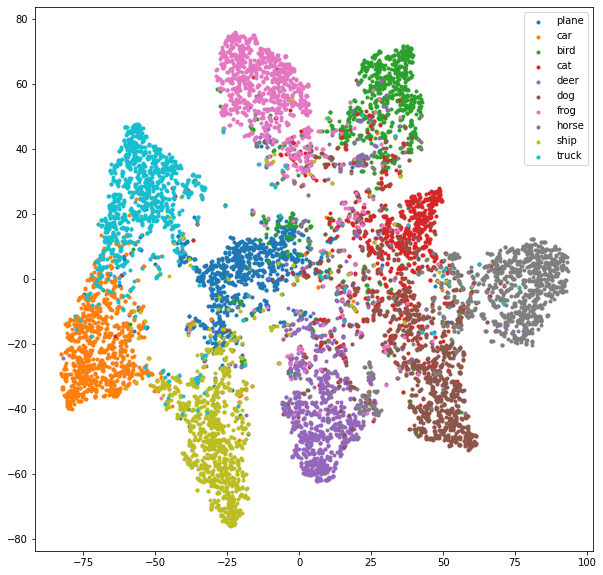

In [39]:
plt.figure(figsize=(10, 10))
cifar = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # actual의 0~9에 대응  
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

# CAR와 TRUCK이 밀집되어 있어 있음...